# About

This notebook checks that training and test files generated in the following scheme are consistent and have similar multidimensional distributions:
* Odd files are taken as training samples, even files are taken as test samples.
* For each particle type take one million tracks (both for training and test): 12 million tracks in total. For our purposes and experiments it is enough statistics for different algorithms training.
* Preserve contribution of each file to the sample for each particle type (proportions of files for each particle type is preserved for selected tracks).

Thus, algorithms can be compared in a correct way.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import root_numpy
import pandas
import numpy
from utils import shrink_floats
import json

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
with open('./features.json', 'r') as f:
    features = json.load(f)

In [4]:
features

{u'CALO': [u'CaloBremMatch',
  u'CaloElectronMatch',
  u'CaloTrMatch',
  u'CaloTrajectoryL',
  u'CaloChargedSpd',
  u'CaloChargedPrs',
  u'CaloChargedEcal',
  u'CaloNeutralSpd',
  u'CaloNeutralPrs',
  u'CaloNeutralEcal',
  u'CaloSpdE',
  u'CaloPrsE',
  u'CaloEcalE',
  u'CaloHcalE',
  u'EcalPIDmu',
  u'HcalPIDmu',
  u'PrsPIDe',
  u'BremPIDe',
  u'EcalPIDe',
  u'HcalPIDe'],
 u'DLL': [u'CombDLLmu', u'CombDLLpi', u'CombDLLp', u'CombDLLe', u'CombDLLk'],
 u'PV': [u'piplus_OWNPV_X',
  u'piplus_OWNPV_Y',
  u'piplus_OWNPV_Z',
  u'piplus_OWNPV_XERR',
  u'piplus_OWNPV_YERR',
  u'piplus_OWNPV_ZERR',
  u'piplus_OWNPV_CHI2',
  u'piplus_OWNPV_NDOF',
  u'piplus_IP_OWNPV',
  u'piplus_IPCHI2_OWNPV'],
 u'RICH': [u'RichAboveMuThres',
  u'RichAboveElThres',
  u'RichAbovePiThres',
  u'RichAboveKaThres',
  u'RichAbovePrThres',
  u'RichUsedR1Gas',
  u'RichUsedR2Gas',
  u'RichDLLbt',
  u'RichDLLpi',
  u'RichDLLe',
  u'RichDLLp',
  u'RichDLLmu',
  u'RichDLLk'],
 u'acceptance': [u'InAccSpd',
  u'InAccPrs',
  u'I

In [5]:
data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree'))
shrink_floats(data)

In [6]:
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree'))
shrink_floats(data_test)

In [7]:
from utils import compute_labels_and_weights, labels_names_correspondence

In [8]:
data['Signal'], _ = compute_labels_and_weights(data.MCParticleType.values)
data_test['Signal'], _ = compute_labels_and_weights(data_test.MCParticleType.values)

In [9]:
from scipy.stats import ks_2samp
for key, f_array in features.items():
    print key
    for value in f_array:
        print '\t', value
        for label, name in labels_names_correspondence.items():
            print "\t\t {name:10} KS: {ks:1.5f}".format(name=name, 
                                                        ks=ks_2samp(data.loc[data.Signal == label, value], 
                                                                    data_test.loc[data_test.Signal == label, value])[0])

muon
	MuonNShared
		 Ghost      KS: 0.00044
		 Electron   KS: 0.00064
		 Muon       KS: 0.00461
		 Pion       KS: 0.00025
		 Kaon       KS: 0.00033
		 Proton     KS: 0.00063
	MuonIsLooseMuon
		 Ghost      KS: 0.00019
		 Electron   KS: 0.00064
		 Muon       KS: 0.00461
		 Pion       KS: 0.00025
		 Kaon       KS: 0.00033
		 Proton     KS: 0.00063
	MuonIsMuon
		 Ghost      KS: 0.00053
		 Electron   KS: 0.00001
		 Muon       KS: 0.00463
		 Pion       KS: 0.00000
		 Kaon       KS: 0.00055
		 Proton     KS: 0.00045
	MuonBkgLL
		 Ghost      KS: 0.00036
		 Electron   KS: 0.00079
		 Muon       KS: 0.00507
		 Pion       KS: 0.00050
		 Kaon       KS: 0.00045
		 Proton     KS: 0.00064
	MuonMuLL
		 Ghost      KS: 0.00031
		 Electron   KS: 0.00072
		 Muon       KS: 0.00477
		 Pion       KS: 0.00046
		 Kaon       KS: 0.00045
		 Proton     KS: 0.00069
PV
	piplus_OWNPV_X
		 Ghost      KS: 0.00206
		 Electron   KS: 0.00076
		 Muon       KS: 0.00132
		 Pion       KS: 0.00186
		 Kaon       KS: 0.00074
		 

In [23]:
from sklearn.cross_validation import train_test_split
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from sklearn.metrics import roc_auc_score

def bootstrap_test_data(data1, data2, features, n_iter=30):
    aucs = {}
    reports = {}
    for i in range(6):
        aucs[labels_names_correspondence[i]] = []
        vals = []
        for _ in range(n_iter):
            data1_train, data1_test = train_test_split(data1[data1.Signal == i], train_size=0.5)
            data2_train, data2_test = train_test_split(data2[data2.Signal == i], train_size=0.5)
            dt_p = SklearnClassifier(DecisionTrainClassifier(n_estimators=1000, depth=6, 
                                                             learning_rate=0.01, n_threads=12), 
                                     features=features)
            dt_p.fit(pandas.concat([data1_train, data2_train]),
                                    [0] * len(data1_train) + [1] * len(data2_train))
            p1 = dt_p.predict_proba(data1_test)[:, 1]
            p2 = dt_p.predict_proba(data2_test)[:, 1]
            vals.append(roc_auc_score([0] * len(data1_test) + [1] * len(data2_test), numpy.concatenate([p1, p2])))
        reports[i] = dt_p.test_on(pandas.concat([data1_test, data2_test]), 
                                  [0] * len(data1_test) + [1] * len(data2_test))
        aucs[labels_names_correspondence[i]] = (numpy.mean(vals), numpy.std(vals)) 
        print labels_names_correspondence[i], aucs[labels_names_correspondence[i]][0], '+/-', 
        print aucs[labels_names_correspondence[i]][1]
    return aucs, reports

In [26]:
pv_features = features.pop('PV')
features_origin = numpy.concatenate(features.values())

In [27]:
len(features_origin)

60

In [28]:
aucs, reports = bootstrap_test_data(data, data_test, features_origin, n_iter=30)

Ghost 0.500344745584 +/- 0.000568286968717
Electron 0.501119681987 +/- 0.000507577730111
Muon 0.509307039638 +/- 0.000322656834768
Pion 0.501215214932 +/- 0.000532132172021
Kaon 0.500835997996 +/- 0.00042176598517
Proton 0.501297895855 +/- 0.000350658022739


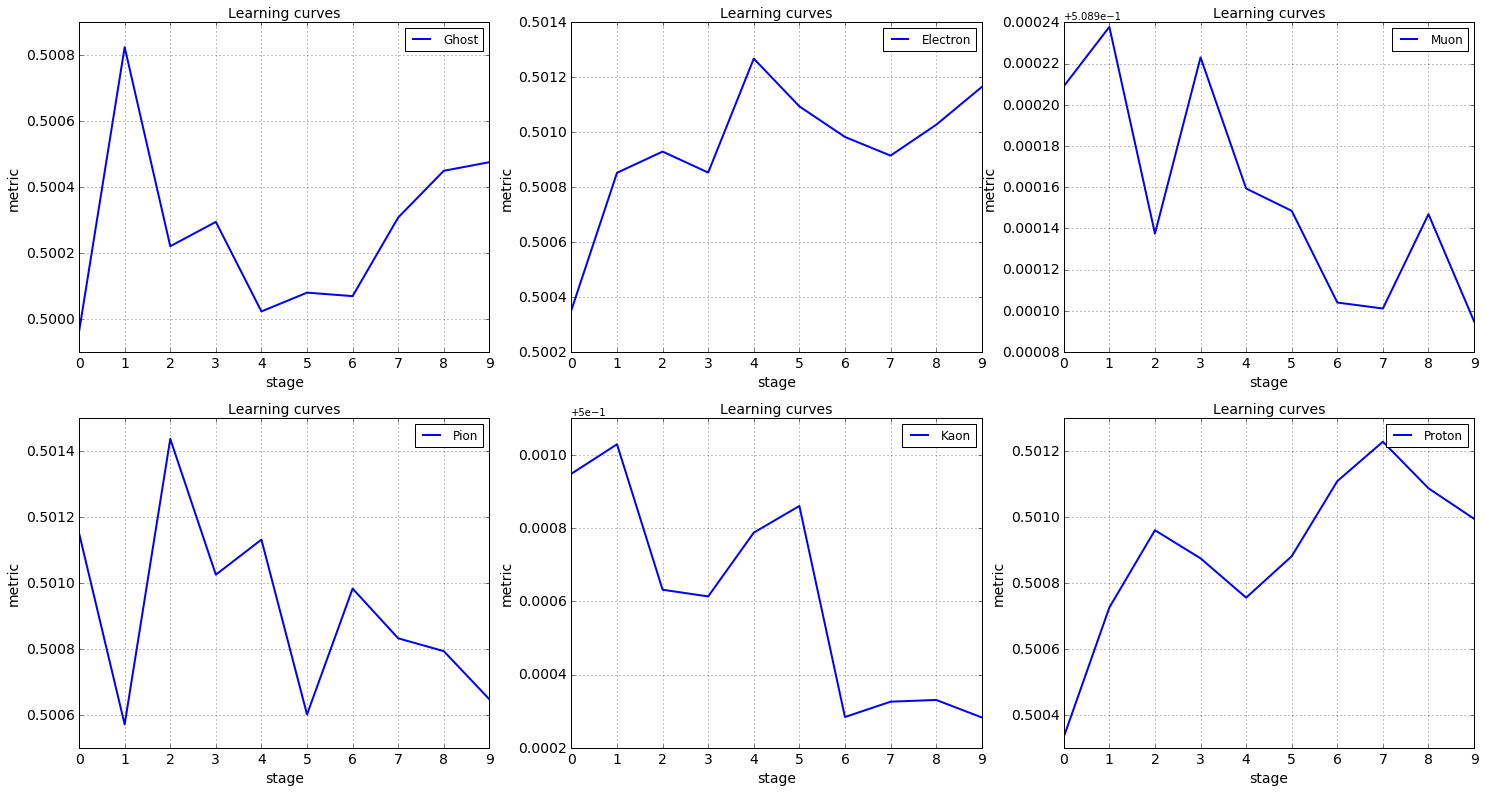

In [29]:
from rep.report.metrics import RocAuc
figure(figsize=(25, 13))
for label, name in labels_names_correspondence.items(): 
    subplot(2, 3, label + 1)
    lc = reports[label].learning_curve(RocAuc(), steps=1)
    lc.plot()
    legend([name])